<a href="https://colab.research.google.com/github/dinesh110598/Spin_glass_NN/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Bimodal triangular EA lattices
The Hamiltonian for the EA model on a 2d triangular lattice with spins {S}:

$ H = \displaystyle\sum_{<i,j>} J_{ij}(p).S_iS_j$ where \<ij\> denotes nearest neighbour positions on a triangular lattice and $J_{ij}(p)$ takes values +1 and -1 with probabilities p and 1-p respectively. We'll consider only the values of p between 0.5 and 1 throughout this notebook.

## Classification between p=0.5 and p=0.7
In this subsection, we will supply a convolutional neural network (CNN) with properly labelled samples for p=0.5 and p=0.7, over multiple realisations of couplings $J_{ij}$ in each category. Later, we'll analyse the network's output for intermediate values of p. Following this, we'll look at 2 point correlation functions of these lattices for the same values and compare the variation of correlation functions with that of neural network output. 

### Imports and dependecies

In [1]:
import math
import numpy as np
import cupy as cp
import tensorflow.keras as tfk
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
from google.colab import output
drive.mount('/content/drive', force_remount=True)
folder_path = "/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/"

Mounted at /content/drive


I've written Numba CUDA kernels (functions that perform calculations inside GPUs using CUDA) for simulating MCMC and parallel tempering algorithms for triangular EA model, in a seperate python file. Let's import the file and its contents inside this notebook:

In [3]:
!curl -o TriEA_kernels.py https://raw.githubusercontent.com/dinesh110598/Spin_glass_NN/master/TriEA_kernels.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6315  100  6315    0     0  24667      0 --:--:-- --:--:-- --:--:-- 24667


In [4]:
from TriEA_kernels import *

In [5]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9fbab0e4-2274-a0ee-7a8c-6f5d3b83d5cb)


### Data generating function

Let's write a function that uses the imported kernels to generate our training data:

In [ ]:
#Jnn = cp.random.choice ([-1,1], (1,48,48,3), 
                        #p=[1.0, 0.]).astype(np.float32)

In [28]:
def generate_train_data (train_len, prob, lat_len=48, m=100):
    shape = (lat_len, lat_len)
    n_ens = train_len//m
    spin = cp.random.choice ([1,-1], (train_len,)+shape).astype(np.int8)
    seed = cp.random.randint (-10000,10000, size=(train_len,)+shape,
                                       dtype=np.int32)
    Jnn = cp.random.choice ([-1,1], (n_ens,)+shape+(3,), 
                                        p=[1-prob, prob]).astype(np.float32)
    energy = cp.zeros ((n_ens,m), np.float32)
    tpb = (1,8,8)
    bpg = (train_len, lat_len//8, lat_len//8)
    perm = cp.arange (0, train_len, dtype=np.int32)
    temp = 0.5
    T = cp.full ((n_ens,m), 0.5, np.float32)
    for _ in range (3000):
        update_red [bpg,tpb] (spin, seed, T, Jnn, perm)
        update_blue [bpg,tpb] (spin, seed, T, Jnn, perm)
        update_green [bpg,tpb] (spin, seed, T, Jnn, perm)

    calc_energy [math.ceil(train_len/64),64] (spin, energy, Jnn)
    spin = 0.5*cp.asnumpy (spin)
    #return cp.asnumpy (energy)
    return spin[...,np.newaxis]#Additional axis required for conv2d layer

In [ ]:
energy = generate_train_data (1000, 0.5)

In [ ]:
np.sort(energy[0]/(48**2))

Let's generate training data for p=0.5 and concatenate with that of p=0.7, with corresponding labels 0 and 1 respectively:

In [58]:
t_lattice = generate_train_data (8000, 0.8)
t_label = np.zeros (8000, np.int32)
t_lattice = np.concatenate ([t_lattice, generate_train_data (8000,0.9)])
t_label = np.concatenate ([t_label, np.ones (8000, np.int32)])
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

Let's gather our numpy data in a single tf.data dataset

In [59]:
train_data = tf.data.Dataset.from_tensor_slices ((t_lattice,t_label))
train_data = train_data.shuffle (buffer_size=16000)

Splitting the dataset into training and validation datasets:

In [60]:
val_data = train_data.take (4000)
train_data = train_data.skip (4000)

In [61]:
val_data = val_data.batch (8)
train_data = train_data.batch (8)

### Neural network initialization and training:

In [62]:
brain = tfk. Sequential([
    tfk.layers.Conv2D(64, (2,2), activation='relu', input_shape = (48,48,1)),
    tfk.layers.MaxPool2D (),
    tfk.layers.Conv2D(64, (2,2), activation='relu'),
    tfk.layers.Flatten(),
    tfk.layers.Dense(64, activation='relu'),
    tfk.layers.Dropout(0.3),
    tfk.layers.Dense(2, activation='softmax')
])

In [63]:
brain.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [64]:
hist = brain.fit (train_data, epochs=1, validation_data=val_data)

1500/1500 [==============================] - 6s 3ms/step - loss: 0.5472 - accuracy: 0.6831 - val_loss: 0.0068 - val_accuracy: 0.9992


In [65]:
brain.save (folder_path+"EA_8_9.h5")

### Neural network predictions for intermediate values

In [ ]:
datax = []
lattice = []
p = 0.5
while (p < 0.601):
    lattice.append (generate_train_data (2000, p))
    datax.append (p)
    p += 0.01
lattice = np.concatenate (lattice)
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [87]:
brain = tfk.models.load_model (folder_path+"EA_7_8.h5")

In [88]:
predictions = brain.predict (lattice[10000:16000])

In [89]:
predictions.shape

(6000, 2)

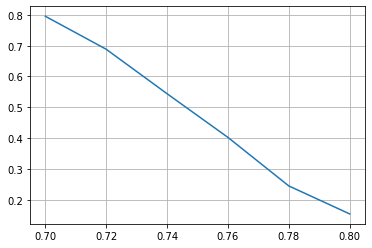

In [90]:
datax = np.arange (0.7, 0.801, 0.02)
datay = []
for i in range (len(datax)):
    datay.append (predictions[1000*i:1000*(i+1),0].mean())
plt.plot (datax, datay)
plt.grid()

### Correlation functions for intermediate values

Let's calculate 2 point correlation functions with distance, averaged over both translations and the three rotations possible on a triangular lattice, using the below expression:
$$ C_2(r) = \frac{<S(x).S(x+r)>_x}{<S(x)^2>_x-<S(x)>^2_x} $$ which assumes translational invariance between averaging over x as opposed to x+r, and that $<S_x>=0$ for all x. The assumptions are perfectly valid for Edwards Anderson model with periodic boundary conditions.

On that note, we'll import a scipy library function pearsonr that'd help us calculate correlation between data without getting our hands dirty:

In [14]:
from scipy.stats import pearsonr

We'll sample Jnn's from appropriate distributions for each p:

In [6]:
Jnn = []
p = 0.5
while (p < 0.9001):
    Jnn.append (np.random.choice ([-1,1], (100,48,48,3), p=[1-p,p]))
    p += 0.02
Jnn = np.concatenate (Jnn)
Jnn = cp.asarray (Jnn)

We've made changes to the previous generating function to run this:

In [8]:
def generate_train_data (train_len, lat_len=48, m=10):
    shape = (lat_len, lat_len)
    n_ens = train_len//m
    spin = cp.random.choice ([1,-1], (train_len,)+shape).astype(np.int8)
    seed = cp.random.randint (-10000,10000, size=(train_len,)+shape,
                                       dtype=np.int32)
    #Jnn = cp.random.choice ([-1,1], (n_ens,)+shape+(3,), 
                                        #p=[1-prob, prob]).astype(np.float32)
    energy = cp.zeros ((n_ens,m), np.float32)
    tpb = (1,8,8)
    bpg = (train_len, lat_len//8, lat_len//8)
    perm = cp.arange (0, train_len, dtype=np.int32)
    temp = 0.5
    T = cp.full ((n_ens,m), 0.5, np.float32)
    for _ in range (3000):
        update_red [bpg,tpb] (spin, seed, T, Jnn, perm)
        update_blue [bpg,tpb] (spin, seed, T, Jnn, perm)
        update_green [bpg,tpb] (spin, seed, T, Jnn, perm)

    calc_energy [math.ceil(train_len/64),64] (spin, energy, Jnn)
    spin = 0.5*cp.asnumpy (spin)
    #return cp.asnumpy (energy)
    return spin[...,np.newaxis]#Additional axis required for conv2d layer

In [9]:
lattice = generate_train_data (Jnn.shape[0]*10)

In [27]:
np.save (folder_path+"Training Data/TriEAlattice.npy", lattice)

In [12]:
TriEA = []
for i in range (21):
    TriEA.append (lattice[1000*i:1000*(i+1)])

In [15]:
corr = np.zeros ((21,3,20,24,24), np.float32)

for n in range (21):
    for r1 in range (24):
        for r2 in range (24):
            x1 = np.ravel (TriEA[n][:,r1,r2,:])
            for r in range (1,21):
                x2 = np.ravel (TriEA[n][:,r1+r,r2,:])
                val, _ = pearsonr (x1,x2)
                corr [n,0,r-1,r1,r2] = (val)

                x2 = np.ravel(TriEA[n][:,r1+int(r-(r%2)*(-1**r2))//2,
                                        r2+r,:])
                val, _ = pearsonr (x1,x2)
                corr [n,1,r-1,r1,r2] = (val)

                x2 = np.ravel(TriEA[n][:,r1-int(r+(r%2)*(-1**r2))//2,
                                        r2+r,:])
                val, _ = pearsonr (x1,x2)
                corr [n,2,r-1,r1,r2] = (val)

corr = np.mean (corr, axis=(1,3,4))

In [ ]:
corr2 = np.zeros ((3,20,24,24), np.float32)

for r1 in range (24):
    for r2 in range (24):
        x1 = np.ravel (TriEA2[:,r1,r2,:])
        for r in range (1,21):
            x2 = np.ravel (TriEA2[:,r1+r,r2,:])
            val, _ = pearsonr (x1,x2)
            corr2 [0,r-1,r1,r2] = (val)

            x2 = np.ravel(TriEA2[:,r1+int(r-(r%2)*(-1**r2))//2,
                                    r2+r,:])
            val, _ = pearsonr (x1,x2)
            corr2 [1,r-1,r1,r2] = (val)

            x2 = np.ravel(TriEA2[:,r1-int(r+(r%2)*(-1**r2))//2,
                                    r2+r,:])
            val, _ = pearsonr (x1,x2)
            corr2 [2,r-1,r1,r2] = (val)

corr2 = np.mean (corr2, axis=(0,2,3))

In [ ]:
corr3 = np.zeros ((3,20,24,24), np.float32)

for r1 in range (24):
    for r2 in range (24):
        x1 = np.ravel (TriEA3[:,r1,r2,:])
        for r in range (1,21):
            x2 = np.ravel (TriEA3[:,r1+r,r2,:])
            val, _ = pearsonr (x1,x2)
            corr3 [0,r-1,r1,r2] = (val)

            x2 = np.ravel(TriEA3[:,r1+int(r-(r%2)*(-1**r2))//2,
                                    r2+r,:])
            val, _ = pearsonr (x1,x2)
            corr3 [1,r-1,r1,r2] = (val)

            x2 = np.ravel(TriEA3[:,r1-int(r+(r%2)*(-1**r2))//2,
                                    r2+r,:])
            val, _ = pearsonr (x1,x2)
            corr3 [2,r-1,r1,r2] = (val)

corr3 = np.mean (corr3, axis=(0,2,3))

In [ ]:
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

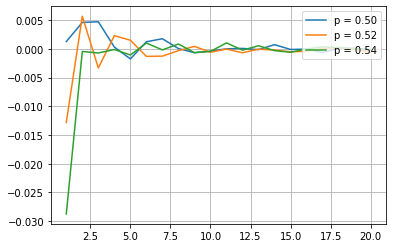

In [ ]:
_, ax = plt.subplots()
ax.plot (range(1,21), list(corr1), label='p = 0.50')
ax.plot (range(1,21), list(corr2), label='p = 0.52')
ax.plot (range(1,21), list(corr3), label='p = 0.54')
ax.legend (loc= 'upper right' )
ax.grid ()
plt.show ()

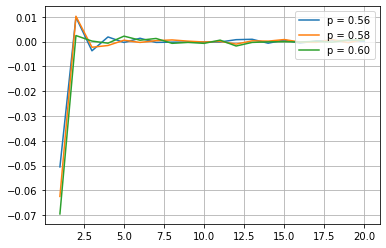

In [ ]:
_, ax = plt.subplots()
ax.plot (range(1,21), list(corr1), label='p = 0.56')
ax.plot (range(1,21), list(corr2), label='p = 0.58')
ax.plot (range(1,21), list(corr3), label='p = 0.60')
ax.legend (loc= 'upper right' )
ax.grid ()
plt.show ()

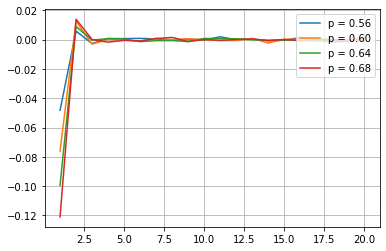

In [24]:
_, ax = plt.subplots()
ax.plot (range(1,21), list(corr[3]), label='p = 0.56')
ax.plot (range(1,21), list(corr[5]), label='p = 0.60')
ax.plot (range(1,21), list(corr[7]), label='p = 0.64')
ax.plot (range(1,21), list(corr[9]), label='p = 0.68')
ax.legend (loc= 'upper right' )
ax.grid ()
plt.show ()

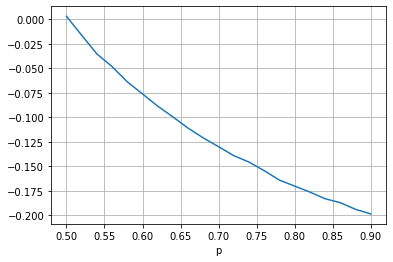

In [26]:
param = (corr[:,0])
probs = np.arange (0.5, 0.91, 0.02)
plt.plot (probs, param)
plt.xlabel ("p")
plt.ylabel ("")
plt.grid ()

In [ ]:
mags = np.mean(t_lattice, axis=(2,3,4))
mags = np.abs (mags)
mags = np.mean (mags, axis=1)

In [ ]:
mags

array([0.01222434, 0.01131912, 0.01041802, 0.00966857, 0.00878114,
       0.00835623, 0.00773389, 0.00723947, 0.00668739, 0.00663856,
       0.00611019])

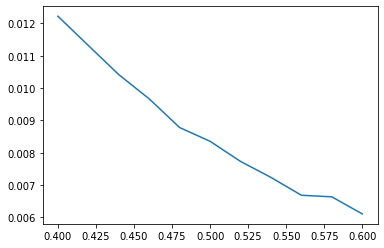

In [ ]:
plt.plot (np.arange (0.4, 0.61, 0.02, float), mags)

# Bimodal EA lattice temperature evolution

In [ ]:
import math
import numpy as np
import cupy as cp
import tensorflow.keras as tfk
import tensorflow as tf
import matplotlib.pyplot as plt
from numba import cuda

## Fixed couplings

Let's fix our couplings and broadcast the same to the entire ensemble:

In [ ]:
Jnn = cp.random.choice ([-1,1], (48,48,2))
Jnn = cp.broadcast_to (Jnn, (10,48,48,2))

In [ ]:
@cuda.jit
def update_sq (spin, seed, T, J_nn, is_black, perm):
    m = T.shape[1]
    z, x, y = cuda.grid (3)
    z = perm[z]
    n = int(math.floor (z / m))
    l = z % m
    p, q = x % 3, y % 2

    def random_uniform ():
        seed[z, x, y] = np.int32((seed[z ,x, y]*1664525 + 1013904223) % 2**31)
        return seed[z, x, y] / (2**31)

    def bvc (x):
        if x == spin.shape[1]:
            x = 0
        return x       

    def sum_nn():  # This adds spins of six neighbours instead of 4 subject to
        #many constraints characteristic of triangular lattices
        value = 0.
        value += J_nn[n,x,y,0]*spin[z, bvc(x+1), y]
        value += J_nn[n,x,y,1]*spin[z, x, bvc(y+1)]
        value += J_nn[n,x-1,y,0]*spin[z, x-1, y]
        value += J_nn[n,x,y-1,1]*spin[z, x-1, y]
        return value

    def calc():
        probs = random_uniform()
        if (probs < math.exp(2*spin[z, x, y]*sum_nn()/T[n,l])):
            spin[z, x, y] *= np.int8(-1)
    
    if is_black==True:
        if (p == 0 and q == 0) or (p == 1 and q == 1):
            calc()

    else:
        if (p == 0 and q == 1) or (p == 1 and q == 0):
            calc()

@cuda.jit
def calc_energy_sq (spin, energy, J_nn):
    z = cuda.grid (1)
    n = int(math.floor (z / energy.shape[1]))
    l = z % energy.shape[1]

    def bvc (x):
        if x == spin.shape[1]:
            x = 0
        return x
    
    def sum_nn_part(x, y, z):  # This adds spins of six neighbours instead of 4 subject to
        #many constraints characteristic of triangular lattices
        value = 0.

        value += J_nn[n,x,y,0]*spin[z, bvc(x+1), y]
        value += J_nn[n,x,y,1]*spin[z, x, bvc(y+1)]
        return value
    
    ener = 0
    if z < spin.shape[0]:
        for x in range (spin.shape[1]):
            for y in range (spin.shape[2]):
                ener += spin[z,x,y]*sum_nn_part(x,y,z)
        energy[n,l] = ener

@cuda.jit
def parallel_temper2 (T, seed, energy, perm):
    z = cuda.grid(1)
    m = T.shape[1]//2
    n = int(math.floor (z/m))
    l = z % m #Takes values between 0 and m//2
    if z < seed.shape[0]//2:
        rand_n = 0 if np.float32(seed[n, 0, 0]/2**31) < 0.5 else 1
        ptr = 2*l + rand_n
        z = 2*z + rand_n
        if ptr < energy.shape[0]-1:
            val0 = perm[z]
            val1 = perm[z+1]
            e0 = energy[n,ptr]
            e1 = energy[n,ptr+1]
            rand_unif = np.float32(seed[z, 1, 0] / 2**31)
            arg = (e0 - e1)*((1./T[n,ptr]) - (1./T[n,ptr+1]))
            if (arg < 0):
                if rand_unif < math.exp(arg):
                    perm[z] = val1
                    perm[z+1] = val0
            else:
                perm[z] = val1
                perm[z+1] = val0

In [ ]:
def generate_train_data (train_len, prob, lat_len=48, m=100):
    shape = (lat_len, lat_len)
    n_ens = train_len//m
    spin = cp.random.choice ([1,-1], (train_len,)+shape).astype(np.int8)
    seed = cp.random.randint (-10000,10000, size=(train_len,)+shape,
                                       dtype=np.int32)
    #Jnn = cp.random.choice ([-1,1], (n_ens,)+shape+(3,), 
                                        #p=[1-prob, prob]).astype(np.float32)
    energy = cp.zeros ((n_ens,m), np.float32)
    tpb = (1,8,8)
    bpg = (train_len, lat_len//8, lat_len//8)
    perm = cp.arange (0, train_len, dtype=np.int32)

    T = cp.linspace (0.5, 4.0, m, dtype=np.float32)
    T = cp.broadcast_to (T, (n_ens,m))
    for _ in range (500):
        for _ in range (4):
            update_sq [bpg,tpb] (spin, seed, T, Jnn, True, perm)
            update_sq [bpg,tpb] (spin, seed, T, Jnn, True, perm)
        calc_energy_sq [math.ceil(train_len/64),64] (spin, energy, Jnn)
        parallel_temper2 [math.ceil(train_len/128),64] (T, seed, energy, perm)

    T = cp.full ((n_ens,m), 0.5, np.float32)
    for _ in range (2000):
        update_sq [bpg,tpb] (spin, seed, T, Jnn, True, perm)
        update_sq [bpg,tpb] (spin, seed, T, Jnn, True, perm)

    calc_energy_sq [math.ceil(train_len/64),64] (spin, energy, Jnn)
    spin = 0.5*cp.asnumpy (spin)
    return cp.asnumpy (energy)

In [ ]:
energy = generate_train_data (1000, 0.5)

In [ ]:
np.sort(energy[0])

array([-1504., -1460., -1456., -1444., -1436., -1432., -1432., -1428.,
       -1412., -1412., -1392., -1388., -1384., -1384., -1372., -1372.,
       -1364., -1364., -1364., -1356., -1356., -1356., -1356., -1352.,
       -1352., -1340., -1324., -1316., -1316., -1312., -1304., -1300.,
       -1292., -1292., -1288., -1284., -1268., -1260., -1260., -1256.,
       -1252., -1236., -1232., -1232., -1232., -1228., -1224., -1224.,
       -1208., -1208., -1208., -1208., -1204., -1200., -1196., -1192.,
       -1188., -1184., -1168., -1168., -1168., -1168., -1164., -1164.,
       -1156., -1156., -1156., -1152., -1152., -1152., -1148., -1148.,
       -1144., -1140., -1132., -1128., -1128., -1116., -1112., -1112.,
       -1112., -1108., -1104., -1104., -1100., -1100., -1100., -1100.,
       -1096., -1092., -1080., -1076., -1072., -1064., -1052., -1032.,
       -1020., -1016., -1004.,  -944.], dtype=float32)

In [ ]:
val = cp.asarray (True)
val == False

array(False)